# Proyek Analisis Sentimen pada Review Sebuah Restoran

Tujuan dari proyek ini adalah untuk membuat sebuah model yang dapat memprediksi apakah review sebuah restoran merupakan review positif atau negatif. Proyek ini menggunakan [dataset yield](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set), dataset tersebut yang berisi kumpulan review terhap sebuah restoran.

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense#, LSTM, Bidirectional
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import json

## Mempersiapkan Dataset

In [3]:
df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Berdasarkan keterangan di atas diketahui bahwa dataset yang digunakan terdiri dari 1000 data dan tidak terdapat *missing value*.

## Preprocessing Data

### Mengubah seluruh text kedalam bentuk lowercase

In [5]:
df['sentence'] = df['sentence'].str.lower()

df.head()

,sentence,label
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### Menghilangkan [stopwords](https://en.wikipedia.org/wiki/Stop_word)

In [6]:
#nltk.download('stopwords')

In [7]:
stop_word = set(stopwords.words('english'))

df['sentence'] = df['sentence'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_word)]))

df.head()

,sentence,label
0,wow... loved place.,1
1,crust good.,0
2,tasty texture nasty.,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great prices.,1


### Melakukan split dataset

In [8]:
sentence = df['sentence'].values
label = df['label'].values

In [9]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, shuffle=False)

print('Training dataset:\n', sentence_train.shape, label_train.shape)
print('\nTest dataset:\n', sentence_test.shape, label_test.shape)

Training dataset:
 (800,) (800,)

Test dataset:
 (200,) (200,)


### Membuat tokenisasi

In [10]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(sentence_train)

In [11]:
word_index = tokenizer.word_index
print(len(word_index))

1732


In [12]:
# Menyimpan word_index kedalam sebuah file json

with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

### Membuat sequences dan melakukan padding

In [13]:
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)


train_padded = pad_sequences(train_sekuens, 
                             maxlen=20,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=20,
                            padding='post',
                            truncating='post')

In [14]:
train_padded.shape

(800, 20)

In [15]:
test_padded.shape

(200, 20)

## Membuat Model

In [16]:
model = tf.keras.Sequential([
    Embedding(2000, 20, input_length=20),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 20)            40000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 43,457
Trainable params: 43,457
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Melatih Model

In [18]:
num_epochs = 30
history = model.fit(train_padded, label_train, 
                    epochs=num_epochs, 
                    validation_data=(test_padded, label_test),
                    verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 7ms/step - loss: 0.6902 - accuracy: 0.5500 - val_loss: 0.7269 - val_accuracy: 0.2400
Epoch 2/30
25/25 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5650 - val_loss: 0.7543 - val_accuracy: 0.2400
Epoch 3/30
25/25 [==============================] - 0s 2ms/step - loss: 0.6779 - accuracy: 0.5650 - val_loss: 0.7799 - val_accuracy: 0.2400
Epoch 4/30
25/25 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.5725 - val_loss: 0.7694 - val_accuracy: 0.2400
Epoch 5/30
25/25 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.6612 - val_loss: 0.7045 - val_accuracy: 0.4100
Epoch 6/30
25/25 [==============================] - 0s 2ms/step - loss: 0.5028 - accuracy: 0.8213 - val_loss: 0.5623 - val_accuracy: 0.8200
Epoch 7/30
25/25 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.9162 - val_loss: 0.5492 - val_accuracy: 0.7250
Epoch 8/30
25/25 [==

## Evaluasi Model

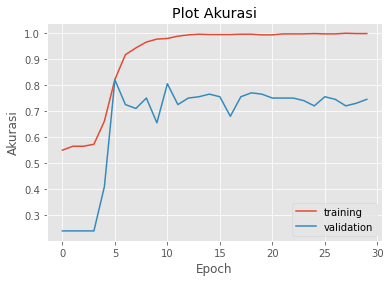

In [19]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.savefig('images/plot_acc.png')
plt.show()

Berdasarkan plot tersebut dapat dilihat bahwa model yang digunakan masih sangat overfit 

## Save Model

In [20]:
model.save("model.h5")

## Convert Model

In [21]:
# Install tensorflowjs

!pip install tensorflowjs

In [22]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2021-10-12 14:43:35.604925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-10-12 14:43:35.605268: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
